## B cells versus T cells
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we note presence/absense changes and quantify fold changes using a T test.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data_raw = load_data.load_max_quant()
#data_raw.head()

Before any analysis, we normalize across runs.

In [2]:
from numpy import nan
from numpy import log2
from statistics import median

data_log2 = log2(data_raw.replace(0,nan))
data_log2_normalized = data_log2.apply(lambda series: series-median(series.dropna()))

These are some methods that check if a value was measured or not and if the protein was measured in each type.

In [3]:
from numpy import isnan
def check_present(row):
    bool_row = []
    for i in row:
        bool_row.append(not isnan(i))
    return sum(bool_row)

def check_three_of_each_type(row, cell_types=["B_cell", "T_cell"]):
    present_in_types = []
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        data_by_type = row.loc[cells_of_type]
        in_type = check_present(data_by_type)
        three_in_type = bool(in_type >= 3)
        present_in_types.append(three_in_type)
    if sum(present_in_types) == len(cell_types):
        return True
    else: return False
    
def check_presence_absence(row, cell_types=["B_cell", "T_cell"], min_reps=3):
    present_in_types = {}
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        data_by_type = row.loc[cells_of_type]
        in_type = check_present(data_by_type)
        present_in_types[i] = in_type
    if 0 in list(present_in_types.values()):#absent in one type
        if present_in_types[cell_types[0]] >= min_reps:
            return "B_cell"
        elif present_in_types[cell_types[1]]>= min_reps:
            return "T_cell"

Here we record which proteins are only identified in one cell type. We'll set these aside for now, in the <code>data_in_one_type</code> dataframe. 

In [4]:
present_only_in = data_log2_normalized.apply(check_presence_absence, axis=1).dropna()
print(present_only_in.value_counts())
data_in_one_type =data_log2_normalized.loc[present_only_in.index]
data_in_one_type['Type'] = present_only_in

B_cell    40
T_cell    36
dtype: int64


Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [5]:
indecies = data_log2_normalized.apply(check_three_of_each_type, axis=1)
data = data_log2_normalized[indecies]

Finally, we will calculate the coeffients of variation for each protein within each of the two cell types. 

In [6]:
from scipy.stats import ttest_ind
from statistics import mean
import pandas as pd

In [7]:
def ttest_wrapper(row, cell_types = ["B_cell", "T_cell"]):
    split_row = []
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        split_row.append(row.loc[cells_of_type])
        
    tstat = ttest_ind(split_row[0],split_row[1])
    tstat = pd.Series(dict(statistic=tstat[0], pvalue=tstat[1]))
    return tstat
    
#Call ttest function
tstats = data.apply(ttest_wrapper, axis=1)

D:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [8]:
#calculate fold_changes
from numpy import log2
def get_fold_changes(row, cell_types=["B_cell", "T_cell"]):
    means = {}
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        data_by_type = row.loc[cells_of_type]
        means[i] = mean(data_by_type)
    return (means[cell_types[0]]-means[cell_types[1]])
        
tstats['log2(B)-log2(T)'] = data.apply(get_fold_changes, axis=1)
#tstats['log2 Fold Change'] = log2(tstats['fold_change'])

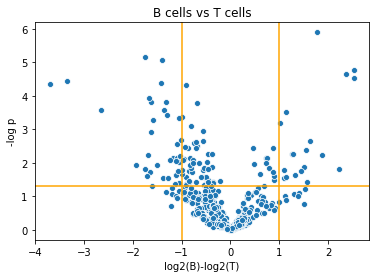

In [9]:
#graph volcano
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10
tstats['-log p'] = -log10(tstats['pvalue'])

figure = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats)
figure.set_title("B cells vs T cells")
plt.axvline(1, color ='orange')
plt.axvline(-1, color ='orange')
plt.axhline(-log10(.05), color ='orange')


In [10]:
#get higher-in-B and higher-in-T proteins
def is_altered(tscore, pvalue=.05,change_factor=2):
    log2_fold_change=log2(change_factor)
    if tscore['pvalue'] < pvalue:
        if tscore['log2(B)-log2(T)'] > log2_fold_change:
            #first type is statistically bigger
            return 'B cells'
        elif tscore['log2(B)-log2(T)'] < -log2_fold_change:
            #second type is statistically bigger
            return "T cells"
        
altered = tstats.apply(is_altered, axis=1).dropna()

In [11]:
altered.value_counts()

T cells    36
B cells    19
dtype: int64

In [12]:
print("P<0.05, >150% of the other type")
print(tstats.apply(is_altered, axis=1, pvalue=.05,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.05, >200% of the other type")
print(tstats.apply(is_altered, axis=1, pvalue=.05,change_factor=2).value_counts()) #Double
print("\nP<0.05, >500% of the other type")
print(tstats.apply(is_altered, axis=1, pvalue=.05,change_factor=5).value_counts()) #5 times larger

print("\nP<0.01, >150% of the other type")
print(tstats.apply(is_altered, axis=1, pvalue=.01,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.01, >200% of the other type")
print(tstats.apply(is_altered, axis=1, pvalue=.01,change_factor=2).value_counts()) #Double
print("\nP<0.01, >500% of the other type")
print(tstats.apply(is_altered, axis=1, pvalue=.01,change_factor=5).value_counts()) #5 times larger

P<0.05, >150% of the other type
T cells    65
B cells    28
dtype: int64

P<0.05, >200% of the other type
T cells    36
B cells    19
dtype: int64

P<0.05, >500% of the other type
T cells    3
B cells    3
dtype: int64

P<0.01, >150% of the other type
T cells    39
B cells    14
dtype: int64

P<0.01, >200% of the other type
T cells    23
B cells    11
dtype: int64

P<0.01, >500% of the other type
T cells    3
B cells    3
dtype: int64


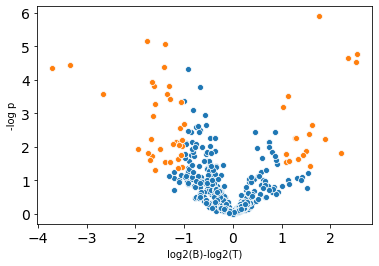

In [13]:
figure = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats)
figure2 = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats.loc[altered.index])
plt.rc('axes',labelsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("B cells vs T cells", fontsize=20)

plt.savefig("data/BvsT.png", dpi=300)

This shows the differentially expressed proteins. Recall that this dataset is restricted to those expressed in at least three of each cell type.

The next step is to identify those proteins and examine the biological pathways they represent to explain why they are different between the two cell types.

Here we get the protein names from the fasta file, which remains the same regardless of which software the data was quantified using.

In [14]:
protein_names = load_data.load_fasta()

In [15]:
protein_names_by_group={}
for ID in data_raw.index:
    if ';' in ID:
        ids = ID.split(';')
        names=''
        for i in ids:
            if i in protein_names.index:
                names=names + protein_names[i] + ';'
        names = names[:-1]
        protein_names_by_group[ID] = names
    else:
        if i in protein_names.index:
            protein_names_by_group[ID]=protein_names[ID]
protein_names_by_group = pd.Series(list(protein_names_by_group.values()), index=protein_names_by_group.keys())

Here we add the names to the <code>tstats</code> dataframe, which contains the fold changes for each protein. Then we can list the proteins that are altered. For readability, we use <code> head()</code> to display the first few or <code>to_csv</code> to write out to a file.

In [16]:
tstats['Name']=protein_names_by_group
tstats.loc[altered.index].sort_values('log2(B)-log2(T)',ascending=False)[['pvalue','log2(B)-log2(T)','Name']].head()
    #.to_csv('data/altered.tsv', sep='\t')

,pvalue,log2(B)-log2(T),Name
Protein IDs,,,
P09960,0.000017,2.536365,LKHA4_HUMAN Leukotriene A-4 hydrolase
Q96KP4,0.000028,2.523796,CNDP2_HUMAN Cytosolic non-specific dipeptidase
P29350,0.000022,2.362278,PTN6_HUMAN Tyrosine-protein phosphatase non-re...
Q16666;Q6K0P9,0.014952,2.224931,IF16_HUMAN Gamma-interferon-inducible protein ...
P30040,0.005952,1.882016,ERP29_HUMAN Endoplasmic reticulum resident pro...


Recall the dataframe of the proteins found only in one type, <code>data_in_one_type</code> we made earlier. Here, we match the names to it as well.

In [17]:
data_in_one_type['Name'] = protein_names_by_group
data_in_one_type[['Type','Name']].sort_values('Type').head()
#data_in_one_type.sort_values('Type').to_csv('data/in_one_type.tsv', sep='\t')

,Type,Name
Protein IDs,,
A6NI72;P14598;A8MVU1,B_cell,NCF1B_HUMAN Putative neutrophil cytosol factor...
Q06187,B_cell,BTK_HUMAN Tyrosine-protein kinase BTK
P11586,B_cell,"C1TC_HUMAN C-1-tetrahydrofolate synthase, cyto..."
P11836,B_cell,CD20_HUMAN B-lymphocyte antigen CD20
P13284,B_cell,GILT_HUMAN Gamma-interferon-inducible lysosoma...


Now that we have the proteins expressed only in or significantly more in, we are going to perform Gene Set Enrichment Analysis (GSEA) to identify the pathways that are more active in one type or the other. For example, we see T cell signalling pathways active in T cells, but not B cells, while B cell signalling pathways are only active in B cells.

In [18]:
data_in_one_type['GeneID']=data_in_one_type.Name.apply(lambda n: str(n).split('_HUMAN')[0])
B_cell_only_geneset = data_in_one_type[(data_in_one_type.Type=='B_cell')].GeneID
T_cell_only_geneset= data_in_one_type[(data_in_one_type.Type=='T_cell')].GeneID

There are a number of characteristic proteins such as B or T cell antigens that are, as expected, only on the associated cell type. The next two code cells retrieve them from the dataframe to display how strongly they are expressed in each sample.

In [19]:
B_col =['Name','Intensity B_cells C10',
        'Intensity B_cells C11','Intensity B_cells C12',
        'Intensity B_cells C13','Intensity B_cells C9']

B_ants = data_in_one_type[B_col].loc[['P11836','P01871',
                      'P13760;Q30167;P13762',
                      'P01903;P01906;P52735',
                      'Q29974;P04229;Q30154;Q9TQE0;Q30134;P79483;P13761',
                      'P04233',
                      'P04440']]
#B_ants

In [20]:
T_col=['Name','Intensity T_cells D10',
       'Intensity T_cells D11','Intensity T_cells D12',
       'Intensity T_cells D13','Intensity T_cells D9']

T_ants = data_in_one_type[T_col].loc[['P06729','P06127','P30203']]
#T_ants